## Método Juale 2019

Para cada proteína se utiliza un programa externo que genera una malla triangular la cual simula la interfaz generada entre el soluto y el medio acuoso. Esta interfaz de ubica a una distancia aproximadamente equivalente a una molécula de agua ($R \approx 1.4$ &Aring;) desde la superficie de la proteína.

Este método nos entrega la posición de cada nodo y define cada triangulo, los cuales consisten de tres nodos.

Se deben importar los siguientes archivos:

* El objeto `vert` es una lista bidimensional de tamaño $n\times3$ que nos entrega la posición de $n$ nodos. Cada fila, `vert[i]` dá la posición $x$, `vert[i][0]`, $y$, `vert[i][1]`, $z$, `vert[i][2]` del i-ésimo nodo.

* El objeto `face` es una lista bidimensional de tamaño $m\times3$ que nos entrega los nodos que componen los $m$ triangulos. Cada fila `face[i]` dá los indices de tres nodos `face[i][0]`, `face[i][1]`, y `face[i][2]`.

#### Elegir el número del grupo funcional para obtener resultados
Los números van desde 0 a 503, ver archivo pdf 


In [13]:
%reset -f

#####################-----CHOOSE FUNCTIONAL GROUP FROM LIST-----#####################


##################################################################################
import numpy as np
import scipy
pi=np.pi
import os
direct=os.getcwd()+"\\mobley_test"

L=next(os.walk(direct))[1]

#for i in L:
#    child=direct+"\\"+i
#    aux=os.listdir(child)
#    for nombre in aux:
        #print(nombre[-4:])
#        if "face"==nombre[-4:] or "vert"==nombre[-4:] :
#            nuevo_nombre=nombre+".txt";print(nuevo_nombre)
#            old_file = os.path.join(child,nombre)
#            new_file = os.path.join(child,nuevo_nombre)
#            os.rename(old_file, new_file)

functional_group = L[0]

def LeerArchivo(filename):
    file = open(direct+"/"+functional_group+"/"+filename+".txt","r").read().split("\n")
    datos=[]
    for i in file:
        datos.append(i.split())
    return(datos)

# Nodos    
vert   = LeerArchivo("surf_d02.vert")    
for j in range(len(vert)):
    del vert[j][-6:]
    vert[j] = [float(i) for i in vert[j]] 
if [] in vert:
    vert.remove([])
n = len(vert)

# Triangulos, definido por tres nodos cada uno
face   = LeerArchivo("surf_d02.face")
for i in range(len(face)):
    del face[i][-2:]
    face[i] = [int(h) for h in face[i]]
    for j in range(len(face[i])):
        face[i][j]= face[i][j]-1
if [] in face:
        face.remove([])
m = len(face)

print("Functional Group:", functional_group)
print("len(vert), n =", n)
print("len(face), m =", m)

Functional Group: 1112_tetrachloroethane
len(vert), n = 229
len(face), m = 454


### Curvatura de cada nodo

El objeto `R_bf` es un arreglo de tamaño $n$ que indica el radio de mejor ajuste que considera el i-ésimo nodo y sus nodos adyacentes. Para obtener este arreglo:

Usamos el arreglo `data_points`, los nodos por esfera tienen la forma:
$$\begin{bmatrix}
    x_{1} & y_{1} & z_{1}\\
    x_{2} & y_{2} & z_{2}\\
    x_{3} & y_{3} & z_{3}\\
    x_{4} & y_{4} & z_{4}\\
    \vdots & \vdots & \vdots\\
    x_{n} & y_{n} & z_{n}
\end{bmatrix}$$

El arreglo `promedio` es el promedio de cada coordenada:
$$\begin{bmatrix}
    \bar{x} & \bar{y} & \bar{z}
\end{bmatrix}$$

Aproximación de coordenadas del centro de la esfera:

$$\begin{bmatrix}
    x_c\\y_c\\z_c
\end{bmatrix} 
= (A^T\cdot A)^{-1}\cdot A^T\cdot B $$

Se definen entonces las matrices $A$ y $B$:
$$ A = 2 \cdot
\begin{bmatrix}
    \displaystyle\sum_{i=1}^{i=n}\frac{x_i(x_i-\overline{x})}{n} & \displaystyle\sum_{i=1}^{i=n}\frac{x_i(y_i-\overline{y})}{n} & \displaystyle\sum_{i=1}^{i=n}\frac{x_i(z_i-\overline{z})}{n}\\
    \displaystyle\sum_{i=1}^{i=n}\frac{y_i(x_i-\overline{x})}{n} & \displaystyle\sum_{i=1}^{i=n}\frac{y_i(y_i-\overline{y})}{n} & \displaystyle\sum_{i=1}^{i=n}\frac{y_i(z_i-\overline{z})}{n}\\
    \displaystyle\sum_{i=1}^{i=n}\frac{z_i(x_i-\overline{x})}{n} & \displaystyle\sum_{i=1}^{i=n}\frac{z_i(y_i-\overline{y})}{n} & \displaystyle\sum_{i=1}^{i=n}\frac{z_i(z_i-\overline{z})}{n}
\end{bmatrix}
$$

$$ B =
\begin{bmatrix}
    \displaystyle\frac{(x_i^2+y_i^2+z_i^2)(x_i-\overline{x})}{n}\\
    \displaystyle\frac{(x_i^2+y_i^2+z_i^2)(y_i-\overline{y})}{n}\\
    \displaystyle\frac{(x_i^2+y_i^2+z_i^2)(z_i-\overline{z})}{n}\\
\end{bmatrix}$$

Finalmente, el radio de la esfera de mejor ajuste se aproxima como: 
$$
R_{bf}=\displaystyle\sqrt{\frac{\sum_{i=1}^{i=n}((x_i-x_c)^2+(y_i-y_c)^2+(z_i-z_c)^2)}{n}}
$$

In [2]:
vector_radio = np.zeros([n,3]) # arreglo de vector entre el centro de la esfera y el nodo en cuestión
R_bf = np.zeros(n)

for i in range(n):
    nodos_esfera=np.zeros(0, dtype = int)
    
    for j in range(m):
        if i in face[j]:
            nodos_esfera=np.append(nodos_esfera,np.array(face[j]))
    nodos_esfera=np.unique(nodos_esfera)
   
    # data_points es un array de las coordenadas de cada nodo para los cuales se hará un ajuste esférico
    data_points=np.zeros([nodos_esfera.size, 3])
    for k in range(nodos_esfera.size):
        data_points[k]=np.array(vert[nodos_esfera[k]])
    
    # Valores promedios de los data_points (x_promedio, y_promedio, z_promedio)
    promedio = np.mean(data_points, axis=0)
    
    # Matrices
    A = np.zeros([3,3])
    B = np.zeros(3)
    for l in range(3):
        B[l] = np.average((data_points[:,0]**2+data_points[:,1]**2+data_points[:,2]**2)*((data_points[:,l]-promedio[l])))
        for p in range(3):
            A[l,p] = np.average(data_points[:,l]*(data_points[:,p]-promedio[p]))
    A = 2*A
    Inverted_Matrix = np.linalg.inv(np.dot(np.transpose(A),A))
    xc, yc, zc = np.dot(np.dot(Inverted_Matrix, np.transpose(A)), B)

    
    vector_radio[i] = np.array(vert[i])-[xc,yc,zc]
    
    R_bf[i] = np.sqrt( np.average( (data_points[:,0]-xc)**2+\
                                  (data_points[:,1]-yc)**2+(data_points[:,2]-zc)**2 ))
#print(*R_bf, sep="\n")

### Volumen

El volumen esta calculado a partir de los $m$ triangulos individuales:

$$ V = \sum_{i=1}^m \bar{x_i} \cdot \hat{n}_{x_{i}} \cdot A_i$$

Donde $\bar{x_{i}}$ es el promedio de la componente $x$ de los vértices y $\hat{n}_{x_{i}}$ es el vector normal.

$$\hat{n}_{x_i} = \frac{\overrightarrow{\left( V_{2}-V_{1} \right)} \times \overrightarrow{\left( V_{3}-V_{1} \right)}}{\| \overrightarrow{\left( V_{2}-V_{1} \right)} \times \overrightarrow{\left( V_{3}-V_{1} \right)}  \|}$$  

Finalmente, el arreglo `area_trig`  de tamaño $m$ nos entrega $A_{i}$, área del i-ésimo triangulo.

$$A_{i}=\frac{1}{2} \| \overrightarrow{\left( V_{2}-V_{1} \right)} \times \overrightarrow{\left( V_{3}-V_{1} \right)}  \|$$

El área de cada triangulo se guardará en un arreglo 1D de tamaño $m$ para usar este dato en cálculos posteriores.

In [3]:
#x_prom_trig  = np.zeros(m)  para guardar estos datos en un arreglo de tamaño m
normal_trig   = np.zeros([m,3])
area_trig     = np.zeros(m)

Vol = 0

for i in range(m): 
    vert1 = np.array(vert[face[i][0]])
    vert2 = np.array(vert[face[i][1]])
    vert3 = np.array(vert[face[i][2]])

    cross_trig = np.cross((vert2-vert1),(vert3-vert1))
    normal_trig[i] = cross_trig/np.linalg.norm(cross_trig)
    
    x_prom_trig   = np.average([vert1[0], vert2[0], vert3[0]]) # Para guardar esto, nombrar x_prom_trig[i]
    normal_x_trig = normal_trig[i][0]
    area_trig[i]  = 0.5*np.linalg.norm(cross_trig)
    
    Vol += x_prom_trig*normal_x_trig*area_trig[i]
    # volumen += x_prom_trig[i]*normal_x_trig[i]*area_trig[i]

### Curvatura promedio por triangulo

El objeto $\bar{R_{i}}$ es un arreglo 1D de tamaño $m$, es el promedio de los radios del mejor ajuste esférico para cada vértice del $i$-ésimo triángulo.
$$
    \bar{R_{i}} =\frac{1}{3}\left( R_{bf, v1} + R_{bf, v2} + R_{bf, v3}\right)
$$

#### Concavo o convexo

Para definir la curvatura, usaremos una de las siguientes convenciónes:
* **1. Curvatura por triangulos** Ya que los nodos en el archivo `face` son dados en sentido anti-horario, calcularemos el producto punto entre la normal del triangulo y la suma de los vectores formados entre los tres vértices de este triangulo y los centros de las esferas de mejor ajuste esférico calculada por cada vértice. El signo de este resultado será multiplicado por el radio promedio calculado para cada triangulo.
* **2. Curvatura por nodos** Se le dá una curvatura a cada punto en vez de por cada triángulo. Se calcula el producto punto entre la suma de las normales de cada triangulo correspondiente a un nodo y el vector formado entre este nodo y el centro de la esfera de mejor ajuste. Luego, el radio por triangulo es el promedio de los radios de los vérties del triangulo.


In [4]:
#normal_trig  # arreglo del normal del triangulo, tamaño (m x 3)
#vector_radio # vector de radio de ajuste esferico por nodo, tamaño (n x 3)

R1_trig = np.zeros(m)
for i in range(m):
    vert1 = np.array(face[i])[0] # índice de vértice 1
    vert2 = np.array(face[i])[1]
    vert3 = np.array(face[i])[2]
    
    suma_R_trig = vector_radio[vert1] + vector_radio[vert2] + vector_radio[vert3]
    signo = int(np.dot(normal_trig[i],suma_R_trig)/np.absolute(np.dot(normal_trig[i],suma_R_trig)))
    R_bf_vertices = np.array([R_bf[vert1], R_bf[vert2], R_bf[vert3]])*signo

    R1_trig[i] = np.average(R_bf_vertices)

    
R2_nodos = np.zeros(n) 
for i in range(n):
    triangulos = np.zeros(0, dtype = int)
    for j in range(m):
        if i in face[j]:
            triangulos = np.append(triangulos,np.array(j))
   
    suma_normales = np.zeros([triangulos.size, 3])
    for k in range(triangulos.size):
        suma_normales[k] = normal_trig[triangulos[k]]
    suma_normales = np.sum(suma_normales, axis=0)
    signo = int(np.dot(suma_normales,vector_radio[i])/np.absolute(np.dot(suma_normales,vector_radio[i])))
    R2_nodos[i] = signo*R_bf[i]
    
R2_trig = np.zeros(m)
for i in range(m):
    vert1 = np.array(face[i])[0] # índice de vértice 1
    vert2 = np.array(face[i])[1]
    vert3 = np.array(face[i])[2]
    
    R_nodos_vertices = np.array([R2_nodos[vert1], R2_nodos[vert2], R2_nodos[vert3]])
    R2_trig[i] = np.average(R_nodos_vertices)

    
comp_radios = np.zeros([m,2])    
comp_radios[:,0] = R1_trig
comp_radios[:,1] = R2_trig
c = (R1_trig*R2_trig)
#for i in range(m):
#    if c[i]<0:
#        print(i)
#print(comp_radios)

## Ecuación de Gibbs

\begin{equation}
    \Delta G \approx \gamma_{lv} \left( 1-\frac{2 \delta}{R} \right) \cdot S + P \cdot V
\end{equation}

Para calcular el primer término, se discretiza por triangulos. El segundo término es una constante.

\begin{equation}
    \Delta G \approx \displaystyle\sum_{i=1}^m \gamma_{lv} \left( 1-\frac{2 \delta_i}{\bar{R}_i} \right) \cdot A_i + P \cdot V
\end{equation}


Consideramos que la presión es constante, y atmosférica, $ P= 101325 \left[ Pa\right]$.

Existen dos modelos de agua, SPC y SPC/E,para definir las constantes de Tolman $\delta$ con respecto a la curvatura y la tensión superficial del agua entre las fases líquido-vapor $\gamma_{lv}$.

#### Modelo SPC:

$\gamma_{lv} = 65\times 10^{-3} \left[ \frac{N}{m} \right]$

$\delta = -0.1521\cdot R^2 + 1.0143\cdot R - 0.7711$ &Aring;

#### Modelo SPC/E:
$\gamma_{lv} = 72\times 10^{-3} \left[ \frac{N}{m} \right]$

$\delta = -0.1524\cdot R^2 + 1.0748 \cdot R - 0.8839$ &Aring;

In [5]:
P = 101300

# Gibbs se calculará primero en Joules por molécula. Lo necesitamos en KCAL/mol
ConvertJ_KCAL=4184 # 1 KCal = 4184 J
Avogadro = 6.022140758e23 # moléculas en un mol


# Función Gibbs:
# modelo_agua = {SPC, SPCE}
# metodo_curvatura = {1, 2}
# tendencia_tolman = {lineal, poly2, poly3} or constant value

def Gibbs_Rabs(modelo_agua, metodo_curvatura, tendencia_tolman):
    tolman  = np.zeros(m)
    for i in range(m):
        if modelo_agua == "SPC":
            gammalv  = 65e-3
            if metodo_curvatura == 1:
                if tendencia_tolman == "lineal":
                    tolman[i]  = 0.1245*abs(R1_trig[i]) - 0.5208
                if tendencia_tolman == "poly2":
                    tolman[i]  = -0.1521*R1_trig[i]**2 + 1.0143*abs(R1_trig[i]) - 0.7711
                if tendencia_tolman == "poly3":
                    tolman[i]  = 0.2476*abs(R1_trig[i]**3) - 2.3508*R1_trig[i]**2 + 7.4965*abs(R1_trig[i]) - 7.1141
            if metodo_curvatura == 2:
                if tendencia_tolman == "lineal":
                    tolman[i]  = 0.1245*abs(R2_trig[i]) - 0.5208
                if tendencia_tolman == "poly2":
                    tolman[i]  = -0.1521*R2_trig[i]**2 + 1.0143*abs(R2_trig[i]) - 0.7711
                if tendencia_tolman == "poly3":
                    tolman[i]  = 0.2476*abs(R2_trig[i]**3) - 2.3508*R2_trig[i]**2 + 7.4965*abs(R2_trig[i]) - 7.1141
        if modelo_agua == "SPCE":
            gammalv = 72e-3
            if metodo_curvatura == 1:
                if tendencia_tolman == "lineal":
                    tolman[i] = 0.1873*abs(R1_trig[i]) - 0.3986
                if tendencia_tolman == "poly2":
                    tolman[i] = -0.1524*R1_trig[i]**2 + 1.0748*abs(R1_trig[i]) - 0.8839
                if tendencia_tolman == "poly3":
                    tolman[i] = 0.2788*abs(R1_trig[i]**3) - 2.6139*R1_trig[i]**2 + 8.2912*abs(R1_trig[i]) - 7.9069
            if metodo_curvatura == 2:
                if tendencia_tolman == "lineal":
                    tolman[i] = 0.1873*abs(R2_trig[i]) - 0.3986
                if tendencia_tolman == "poly2":
                    tolman[i] = -0.1524*R2_trig[i]**2 + 1.0748*abs(R2_trig[i]) - 0.8839
                if tendencia_tolman == "poly3":
                    tolman[i] = 0.2788*abs(R2_trig[i]**3) - 2.6139*R2_trig[i]**2 + 8.2912*abs(R2_trig[i]) - 7.9069

    G = 0
    if metodo_curvatura == 1:
        for i in range(m):
            G += gammalv * area_trig[i]*(10**(-20)) *(1-2*((tolman[i])  /R1_trig[i]) )
    if metodo_curvatura == 2:
        for i in range(m):
            G += gammalv * area_trig[i]*(10**(-20)) *(1-2*((tolman[i])  /R2_trig[i]) )
    G += Vol*P*10**(-30) 
    G *= Avogadro/ConvertJ_KCAL
    nominal = 1.00
    er = abs((G-nominal)/nominal)*100
    return print("**Gibbs no-polar** \n Modelo de agua: ", modelo_agua, "\n Método curvatura: ",\
          metodo_curvatura, "\n Tendencia tolman: ", tendencia_tolman, "\n G =", round(G,3), "kCal/mol",\
                 "\n error =", round(er,3), "% \n ----------------")

gr_spc_11 = Gibbs_Rabs("SPC", 1, "lineal")
gr_spc_12 = Gibbs_Rabs("SPC", 1, "poly2")
gr_spc_13 = Gibbs_Rabs("SPC", 1, "poly3")

gr_spc_21 = Gibbs_Rabs("SPC", 2, "lineal")
gr_spc_22 = Gibbs_Rabs("SPC", 2, "poly2")
gr_spc_23 = Gibbs_Rabs("SPC", 2, "poly3")

gr_spce_11 = Gibbs_Rabs("SPCE", 1, "lineal")
gr_spce_12 = Gibbs_Rabs("SPCE", 1, "poly2")
gr_spce_13 = Gibbs_Rabs("SPCE", 1, "poly3")

gr_spce_21 = Gibbs_Rabs("SPCE", 2, "lineal")
gr_spce_22 = Gibbs_Rabs("SPCE", 2, "poly2")
gr_spce_23 = Gibbs_Rabs("SPCE", 2, "poly3")

**Gibbs no-polar** 
 Modelo de agua:  SPC 
 Método curvatura:  1 
 Tendencia tolman:  lineal 
 G = 13.622 kCal/mol 
 error = 1262.207 % 
 ----------------
**Gibbs no-polar** 
 Modelo de agua:  SPC 
 Método curvatura:  1 
 Tendencia tolman:  poly2 
 G = 7.937 kCal/mol 
 error = 693.674 % 
 ----------------
**Gibbs no-polar** 
 Modelo de agua:  SPC 
 Método curvatura:  1 
 Tendencia tolman:  poly3 
 G = 13.976 kCal/mol 
 error = 1297.598 % 
 ----------------
**Gibbs no-polar** 
 Modelo de agua:  SPC 
 Método curvatura:  2 
 Tendencia tolman:  lineal 
 G = 11.688 kCal/mol 
 error = 1068.819 % 
 ----------------
**Gibbs no-polar** 
 Modelo de agua:  SPC 
 Método curvatura:  2 
 Tendencia tolman:  poly2 
 G = 5.534 kCal/mol 
 error = 453.411 % 
 ----------------
**Gibbs no-polar** 
 Modelo de agua:  SPC 
 Método curvatura:  2 
 Tendencia tolman:  poly3 
 G = -10.15 kCal/mol 
 error = 1115.006 % 
 ----------------
**Gibbs no-polar** 
 Modelo de agua:  SPCE 
 Método curvatura:  1 
 Tendencia 

In [6]:
# Función Gibbs:
# modelo_agua = {SPC, SPCE}
# metodo_curvatura = {1, 2}
# tendencia_tolman = {lineal, poly2, poly3} or constant value

def Gibbs(modelo_agua, metodo_curvatura, tendencia_tolman):
    tolman  = np.zeros(m)
    for i in range(m):
        if modelo_agua == "SPC":
            gammalv  = 65e-3
            if metodo_curvatura == 1:
                if tendencia_tolman == "lineal":
                    tolman[i]  = 0.1245*(R1_trig[i]) - 0.5208
                if tendencia_tolman == "poly2":
                    tolman[i]  = -0.1521*R1_trig[i]**2 + 1.0143*(R1_trig[i]) - 0.7711
                if tendencia_tolman == "poly3":
                    tolman[i]  = 0.2476*(R1_trig[i]**3) - 2.3508*R1_trig[i]**2 + 7.4965*(R1_trig[i]) - 7.1141
            if metodo_curvatura == 2:
                if tendencia_tolman == "lineal":
                    tolman[i]  = 0.1245*(R2_trig[i]) - 0.5208
                if tendencia_tolman == "poly2":
                    tolman[i]  = -0.1521*R2_trig[i]**2 + 1.0143*(R2_trig[i]) - 0.7711
                if tendencia_tolman == "poly3":
                    tolman[i]  = 0.2476*(R2_trig[i]**3) - 2.3508*R2_trig[i]**2 + 7.4965*(R2_trig[i]) - 7.1141
        if modelo_agua == "SPCE":
            gammalv = 72e-3
            if metodo_curvatura == 1:
                if tendencia_tolman == "lineal":
                    tolman[i] = 0.1873*(R1_trig[i]) - 0.3986
                if tendencia_tolman == "poly2":
                    tolman[i] = -0.1524*R1_trig[i]**2 + 1.0748*(R1_trig[i]) - 0.8839
                if tendencia_tolman == "poly3":
                    tolman[i] = 0.2788*(R1_trig[i]**3) - 2.6139*R1_trig[i]**2 + 8.2912*(R1_trig[i]) - 7.9069
            if metodo_curvatura == 2:
                if tendencia_tolman == "lineal":
                    tolman[i] = 0.1873*(R2_trig[i]) - 0.3986
                if tendencia_tolman == "poly2":
                    tolman[i] = -0.1524*R2_trig[i]**2 + 1.0748*(R2_trig[i]) - 0.8839
                if tendencia_tolman == "poly3":
                    tolman[i] = 0.2788*(R2_trig[i]**3) - 2.6139*R2_trig[i]**2 + 8.2912*(R2_trig[i]) - 7.9069

    G = 0
    if metodo_curvatura == 1:
        for i in range(m):
            G += gammalv * area_trig[i]*(10**(-20)) *(1-2*((tolman[i])  /R1_trig[i]) )
    if metodo_curvatura == 2:
        for i in range(m):
            G += gammalv * area_trig[i]*(10**(-20)) *(1-2*((tolman[i])  /R2_trig[i]) )
    G += Vol*P*10**(-30) 
    G *= Avogadro/ConvertJ_KCAL
    nominal = 1.00
    er = abs((G-nominal)/nominal)*100
    return print("**Gibbs no-polar**\n Modelo de agua: ", modelo_agua, "\n Método curvatura: ",\
          metodo_curvatura, "\n Tendencia Tolman: ", tendencia_tolman, "\n G =", round(G,3), "kCal/mol",\
                 "\n error =", round(er,3), "% \n ----------------")
    
    
g_spc_11 = Gibbs("SPC", 1, "lineal")
g_spc_12 = Gibbs("SPC", 1, "poly2")
g_spc_13 = Gibbs("SPC", 1, "poly3")

g_spc_21 = Gibbs("SPC", 2, "lineal")
g_spc_22 = Gibbs("SPC", 2, "poly2")
g_spc_23 = Gibbs("SPC", 2, "poly3")

g_spce_11 = Gibbs("SPCE", 1, "lineal")
g_spce_12 = Gibbs("SPCE", 1, "poly2")
g_spce_13 = Gibbs("SPCE", 1, "poly3")

g_spce_21 = Gibbs("SPCE", 2, "lineal")
g_spce_22 = Gibbs("SPCE", 2, "poly2")
g_spce_23 = Gibbs("SPCE", 2, "poly3")

**Gibbs no-polar**
 Modelo de agua:  SPC 
 Método curvatura:  1 
 Tendencia Tolman:  lineal 
 G = 12.327 kCal/mol 
 error = 1132.703 % 
 ----------------
**Gibbs no-polar**
 Modelo de agua:  SPC 
 Método curvatura:  1 
 Tendencia Tolman:  poly2 
 G = -2.614 kCal/mol 
 error = 361.395 % 
 ----------------
**Gibbs no-polar**
 Modelo de agua:  SPC 
 Método curvatura:  1 
 Tendencia Tolman:  poly3 
 G = -71.688 kCal/mol 
 error = 7268.774 % 
 ----------------
**Gibbs no-polar**
 Modelo de agua:  SPC 
 Método curvatura:  2 
 Tendencia Tolman:  lineal 
 G = 10.309 kCal/mol 
 error = 930.932 % 
 ----------------
**Gibbs no-polar**
 Modelo de agua:  SPC 
 Método curvatura:  2 
 Tendencia Tolman:  poly2 
 G = -5.7 kCal/mol 
 error = 669.957 % 
 ----------------
**Gibbs no-polar**
 Modelo de agua:  SPC 
 Método curvatura:  2 
 Tendencia Tolman:  poly3 
 G = -96.652 kCal/mol 
 error = 9765.216 % 
 ----------------
**Gibbs no-polar**
 Modelo de agua:  SPCE 
 Método curvatura:  1 
 Tendencia Tolman

## Tri-plot

In [7]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

datos1 = np.array(vert)
datos2 = np.zeros([n,3])
for i in range(n):
    datos2[i] = np.array(datos1[i]) 

triangulos1 = np.array(face)
triangulos2 = np.zeros([m,3])
for j in range(m):
    triangulos2[j] = np.array(triangulos1[j])
    
x_plt = datos2[:,0]
y_plt = datos2[:,1]
z_plt = datos2[:,2]

triang = mtri.Triangulation(x_plt, y_plt, triangulos2)

##########################################
################   3D    #################
##########################################

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z_plt, cmap='cool')
# cmap options https://matplotlib.org/examples/color/colormaps_reference.html
ax.scatter(x_plt,y_plt,z_plt, marker='.', s=10, c="black", alpha=0.5)

ax.view_init(elev=-15, azim=10)
#ax.view_init(elev=60, azim=-45)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

<Figure size 640x480 with 1 Axes>

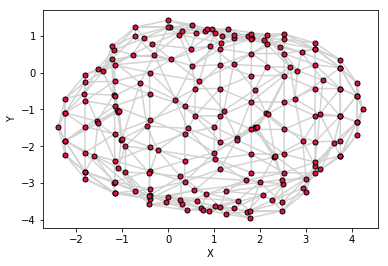

In [8]:
##########################################
################   2D    #################
##########################################

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="#DC143C", markeredgecolor="black", markersize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()